<h1>Analysis of Beorn D2 chip</h1>
Online analysis script used to pre-analyse the data collected during the cooldown of the chip.

In [2]:
sample_name = 'beorn_d2'                    # name of the chip in the fridge
db_name = '20220608_sc_s21_meas.db'   # name of the database
user = 'sc'                               # who is performing measurements

<h3>Basic imports</h3>

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from resonator_tools import circuit

import qcodes as qc
from qcodes import initialise_database, load_by_run_spec
from qcodes.dataset.plotting import plot_by_id

import scipy.optimize

db_path  = os.path.join(r'D:\QMET' + '\\' + sample_name + '\\', db_name)

<h2>Data loading</h2>

In [3]:
RUN_ID = 11
qc.initialise_or_create_database_at(db_path)
dataset = qc.load_by_run_spec( captured_run_id=RUN_ID)
print(dataset)

s21_dict = dataset.to_pandas_dataframe_dict()

#plt.plot(f, phi)

meas_6.24_tone_0.1_25ghz_long #11@D:\QMET\beorn_d2\20220608_sc_s21_meas.db
--------------------------------------------------------------------------
mw_source_power - numeric
mw_source_frequency - numeric
ZNB20_S21_S21_frequency - numeric
ZNB20_S21_magnitude - numeric
ZNB20_S21_phase - numeric


In [4]:
s21_dict['ZNB20_S21_magnitude']

ZNB20_S21_magnitude
mw_source_power mw_source_frequency ZNB20_S21_S21_frequency                     
-30.0           1.000000e+08        6.240000e+09                        0.007337
                1.010000e+08        6.240000e+09                        0.007306
                1.020001e+08        6.240000e+09                        0.007291
                1.030001e+08        6.240000e+09                        0.007314
                1.040002e+08        6.240000e+09                        0.007305
...                                                                          ...
 10.0           2.499600e+10        6.240000e+09                        0.007035
                2.499700e+10        6.240000e+09                        0.007044
                2.499800e+10        6.240000e+09                        0.007067
                2.499900e+10        6.240000e+09                        0.007011
                2.500000e+10        6.240000e+09                        0.007077

[996000 rows x 1 columns]

In [5]:

# f = s21_dict['ZNB20_S21_S21_frequency']['ZNB20_S21_S21_frequency'][0:1001]
mag_dict = s21_dict['ZNB20_S21_magnitude'].reset_index()
phi_dict = s21_dict['ZNB20_S21_phase'].reset_index()
mag = mag_dict['ZNB20_S21_magnitude'].to_numpy()
phi = phi_dict['ZNB20_S21_phase'].to_numpy()
pwr = mag_dict['mw_source_power'].to_numpy()
mw_f = mag_dict['mw_source_frequency'].to_numpy()

In [6]:
N = np.unique(pwr).shape[0]
size = (N,-1)

mag = np.reshape(mag,size)
pwr = np.reshape(pwr, size)
# pwr = np.squeeze(pwr)
mw_f = np.reshape(mw_f, size)
phi = np.reshape(phi, size)

In [7]:
pwr.shape

(40, 24900)

In [8]:
normalized_mag = np.empty(mag.shape)
normalized_phase = np.empty(mag.shape)
for i in range(mag.shape[0]):
    # Normalize for each power value
    x = mag[i, :]
    y = phi
    normalized_mag[i, :] = x/np.max(np.abs(x))

<h2>Data analysis and plotting</h2>

In [9]:
def check_for_peaks(base_array, threshold):
    '''Detect the argmax of peaks whose value is above threshold'''
    
    # study =base_array-np.min(np.abs(base_array)) #if we want relative threshold
    study = base_array #absolute threshold
    peaks=[]
    idx=0
    L = len(study)
    while idx < L:
        ph = study[idx]
        if ph > threshold:
            if idx < L-1:
                i2 = idx+1
                ph2= ph+1
                while  i2 < L and ph2 >= ph:
                    ph2 = study[i2]
                    i2 +=1
                    
                peaks.append(idx + np.argmax(study[idx:i2])) 
                idx=i2
            else: 
                peaks.append(idx)
        idx+=1
    
    return peaks

def remove_overdetection_peaks(base_array, freq_array, peaks, minimum_freq_spacing):
    '''Remove the peaks indexes that are within minimum_freq_spacing of each other'''
    
    spacing = 0 
    grouped_peaks = [[peaks[0]]]
    for i in range(1, len(peaks)):
        pk = peaks[i]
        spacing = np.abs(freq_array[pk] - freq_array[peaks[i-1]])

        if spacing <= minimum_freq_spacing :
            grouped_peaks[-1].append(pk)
        else :
            grouped_peaks.append([pk])
            
    new_peaks = []
    for group in grouped_peaks:
        if len(group) > 1:
            n_peaks = group[0] + np.argmax(base_array[group[0]:group[-1]])
        else :
            n_peaks = group[0]
        new_peaks.append(n_peaks)
    
    return new_peaks

In [10]:
mag_peaks = []
phase_peaks= []
for i in range(mag.shape[0]):
    m_peaks = check_for_peaks(10*np.log(mag[i,:]), threshold=-50)
    m_peaks = remove_overdetection_peaks(10*np.log(mag[i,:]), mw_f[i, :], m_peaks, minimum_freq_spacing=0.3e9)
    mag_peaks.append(m_peaks)
    
    phi_peaks = check_for_peaks(phi[i, :], threshold = 2.7)
    phi_peaks = remove_overdetection_peaks(phi[i, :], mw_f[i, :], phi_peaks, minimum_freq_spacing=0.5e9)
    phase_peaks.append(phi_peaks)

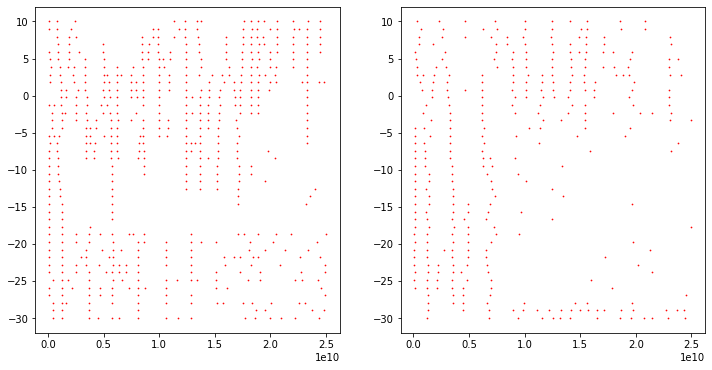

In [11]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)


for i in range(mag.shape[0]):
    peaks =  mag_peaks[i]
    ax1.scatter(mw_f[i, peaks],[pwr[i, 0]]*len(peaks), color='r', s=0.5)
    
    peaks =  phase_peaks[i]
    ax2.scatter(mw_f[i, peaks],[pwr[i, 0]]*len(peaks), color='r', s=0.5)

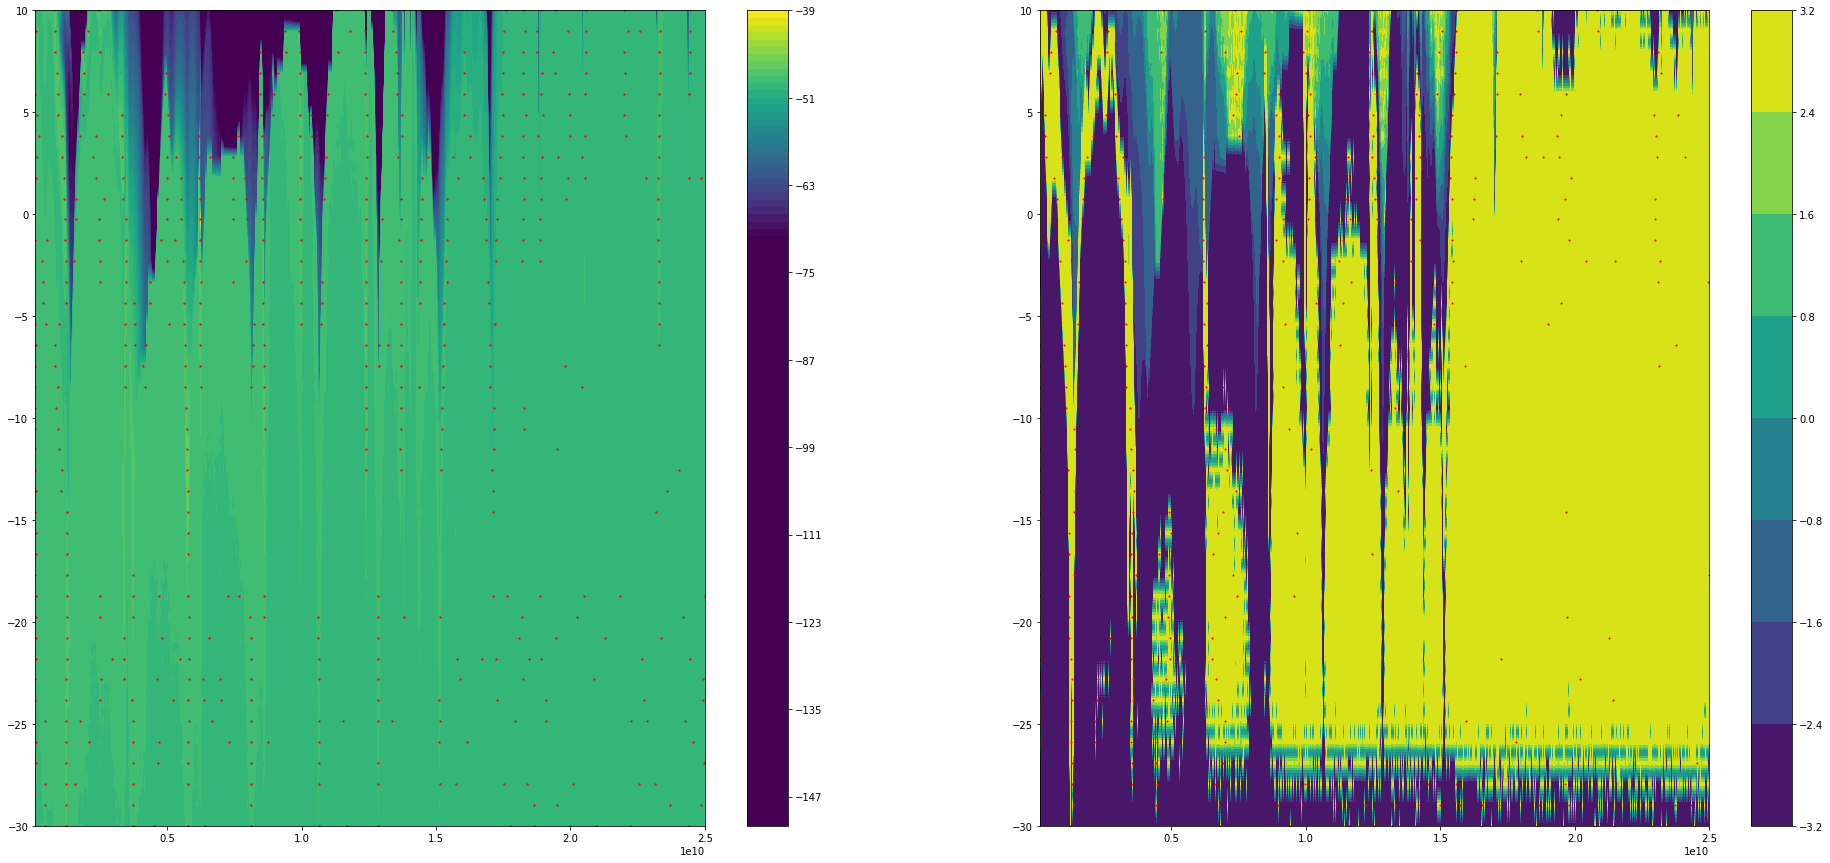

In [12]:
fig = plt.figure(figsize=(30+3,15))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

cp = ax1.contourf(mw_f, pwr, 10*np.log(mag), levels=125, vmin= -70)
cp2 = ax2.contourf(mw_f, pwr, phi)

for i in range(mag.shape[0]):
    peaks =  mag_peaks[i]
    ax1.scatter(mw_f[i, peaks],[pwr[i, 0]]*len(peaks), color='r', s=1.5)
    
    peaks =  phase_peaks[i]
    ax2.scatter(mw_f[i, peaks],[pwr[i, 0]]*len(peaks), color='r', s=1.2)

plt.colorbar(cp, ax=ax1)
plt.colorbar(cp2, ax=ax2)

In [22]:
%matplotlib

Using matplotlib backend: Qt5Agg


In [26]:

plt.figure(figsize=(10, 10))
# plt.plot(mw_f[-1, :], np.log(np.abs(mag))[-1, :])
plt.plot(mw_f[1, :], np.log(np.abs(mag))[30, :])

N = mag.shape[0]
# plt.plot(mw_f[5, :], np.log(np.abs(mag))[30, :])
# plt.xlim([4e8,2e9])

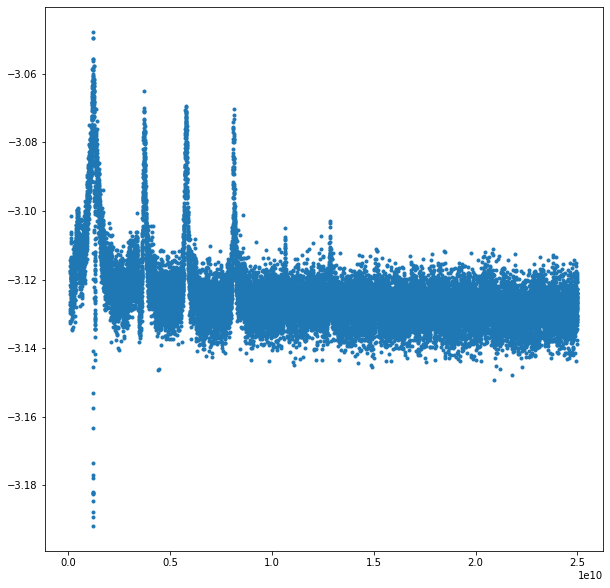

In [18]:
plt.figure(figsize=(10,10))
plt.plot(mw_f[5, :], np.unwrap(phi)[1, :], '.')
# plt.xlim([0,0.5e10])

[1.24504599e+09 3.72414555e+09 5.77422788e+09 8.12132214e+09]


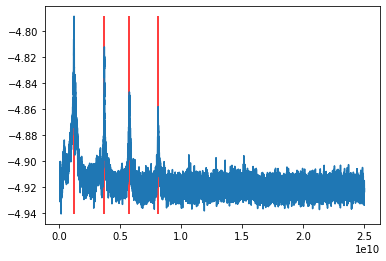

In [15]:
k = 1
x0=0
x1 = -1
m_peaks = check_for_peaks(np.log(np.abs(mag)[k, x0:x1]), threshold=-4.88)
m_peaks = remove_overdetection_peaks(np.log(np.abs(mag)[k, x0:x1]) , mw_f[k, x0:x1], m_peaks, minimum_freq_spacing=1e9)
plt.plot(mw_f[k, x0:x1], np.log(np.abs(mag))[k, x0:x1])
plt.vlines(mw_f[k, m_peaks], np.min(np.log(np.abs(mag))[k, x0:x1]), np.max(np.log(np.abs(mag))[k, x0:x1]), 'r')
print(mw_f[k, m_peaks])

In [16]:
# a0 = mw_f[1, mag_peaks[1], 0]
# i = np.abs(pwr[:, 0,0] +10).argmin()
# a1 = mw_f[i, mag_peaks[i][-3:-1], 0]
# found_peaks = np.concatenate([a0, a1])
# # k_idx = [1,2,3,4,5,6,7,9,10]
# k_idx  = [0,1,2,3,4,5,6,8,9]

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [8]:
found_peaks = [1.243e9, 3.722e9, 5.787e9, 8.121e9, 10.633e9, 12.85e9, 15.15e9, 17e9, 18.85e9]
found_peaks = np.array(found_peaks)
k_idx = [0,1,2,3,4,5,6,7,8]
k_idx = np.array(k_idx)

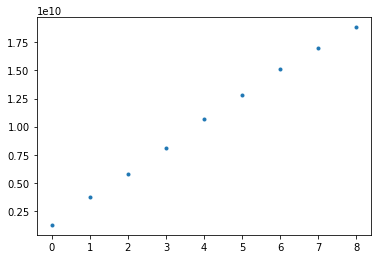

In [5]:
plt.plot(k_idx, found_peaks, '.')

Plasma frequency: 4.97e+10 Hz, Cg/Cj: 1.67e-04


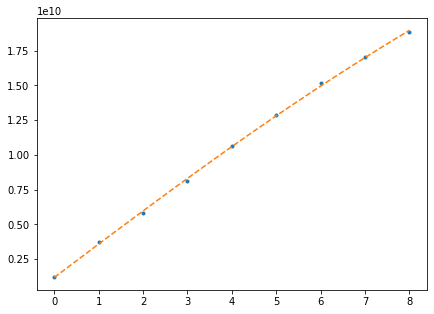

In [12]:
def dispersion_fun(x, omega_p, cap_ratio, cste):
    ka = x*np.pi/5000 + cste # 5000 junctions
    
    val = omega_p*np.sqrt((1-np.cos(ka))/(1-np.cos(ka)+0.5*cap_ratio))
    return val

fit = scipy.optimize.curve_fit(dispersion_fun, k_idx, found_peaks/(found_peaks[-1]), bounds=(0, np.inf),  maxfev=10000 )
# print(fit[0])
plt.figure(figsize=(7,5))
plt.plot(k_idx, found_peaks, '.')
ks = np.linspace(0,k_idx[-1], num=250)
plt.plot(ks, [dispersion_fun(k, *fit[0])*found_peaks[-1] for k in ks] ,'--')
print("Plasma frequency: %.2e Hz, Cg/Cj: %.2e" % (fit[0][0]*found_peaks[-1], fit[0][1]))

In [258]:
found_peaks[3]

7033615946.75496

,Qi_dia_corr,Qi_no_corr,absQc,Qc_dia_corr,Ql,fr,theta0,phi0,phi0_err,Ql_err,absQc_err,fr_err,chi_square,Qi_no_corr_err,Qi_dia_corr_err
0,1.19e+04,1.19e+04,1.08e+03,1.08e+03,9.88e+02,5.22e+09,3.12e+00,-1.94e-02,1.89e-03,1.67e+00,1.30e+00,5.50e+03,1.55e-04,1.74e+02,1.73e+02


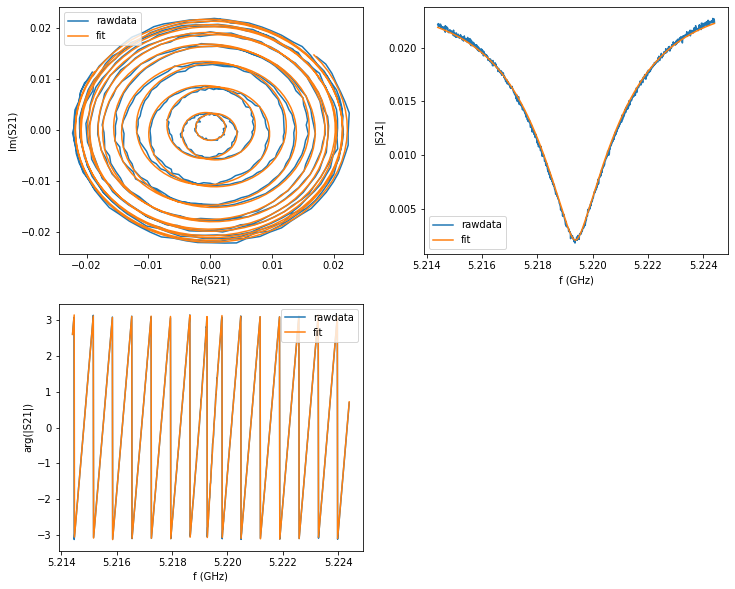

single photon limit: -135.04342480341646 dBm
photons in reso for input -120dBm: 31.940556629793647 photons


In [14]:
port1 = circuit.notch_port(f_data = f, z_data_raw = mag * np.exp(1j*phi))
port1.autofit()

display(pd.DataFrame([port1.fitresults]).applymap(lambda x: "{0:.2e}".format(x)))
port1.plotall()
#plt.rcParams["figure.figsize"] = (12,10)

print("single photon limit:", port1.get_single_photon_limit(diacorr=True), "dBm")
print("photons in reso for input -120dBm:", port1.get_photons_in_resonator(-120,unit='dBm',diacorr=True), "photons")